# **Linear Discriminant Analysis**
Linear Discriminant Analysis (LDA) is a classification and dimensionality reduction algorithm that allows you to separate classes in the best possible way. The main idea of LDA is to assume a multidimensional normal distribution of features within classes and search for their linear transformation, which maximizes interclass variance and minimizes intraclass variance. In other words, objects of different classes should have a normal distribution and be located as far from each other as possible, and of the same class as close as possible.

Despite the presence of logistic regression, in some cases LDA may be the preferred option for several reasons:
- since LDA is based on modeling the distribution of data in each class, it requires fewer parameters to evaluate, which reduces the tendency to overfitting;
- with a large number of classes and their good linear separation, it is more stable and efficient;
- can be used to reduce the dimension without using additional methods.

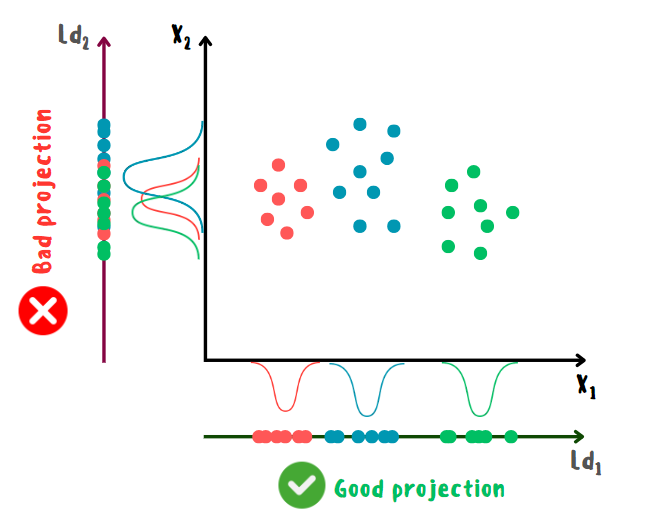

### **The principle of LDA operation**
The algorithm is constructed as follows:
- 1) initially, prior probabilities and mean values of features are calculated for all classes;
- 2) based on the obtained values, the (covariance) scatter matrices between classes and within classes are calculated;
- 3) next the eigenvectors and eigenvalues are calculated for the linear Fisher discriminant, which is determined by the ratio of the matrices from step 2;
- 4) the eigenvectors are sorted in descending order according to the eigenvalues and are called *discriminant vectors*, which are used to calculate the weights of the model;
- 5) based on the obtained weights and prior probabilities, the bias vector is calculated;
- 6) the new feature space of a smaller dimension is a linear combination of the original features and discriminant vectors and is called a *discriminant subspace*;
- 7) predicted classes are the maximum estimate of the linear combination of the test sample and weights + bias.

**Formulas for calculations**

$\mu_k = \frac{1}{n_k} \sum \limits_{i \in C_k} x_i \ - \ $ mean features  by class

$\mu = \frac{1}{n} \sum \limits_{i=1}^n x_i \ - \ $ mean features

$S_W = \sum \limits_{k=1}^K \sum \limits_{i \in C_k} (x_i - \mu_k)^T (x_i - \mu_k) \ - \ $ within-class covariance matrix

$S_B = \sum \limits_{k=1}^K \pi_k (\mu_k - \mu)^T (\mu_k - \mu) \ - \ $ between-class covariance matrix

$S_W^{-1} S_B v = \lambda v$

$w = \mu_k d_v d_v^T \ - \ $ weights

$b = \log \pi_k - \frac{1}{2} diag(\mu_k w^T) \ - \ $ bias

$\delta(x) = argmax(wx + b) \ \ by \ \ class \ - \ $ prediction

$\lambda - eigenvalues, \ \ v - eigenvectors$

$\pi_k \ - \ $ a prior probability of a class k

$d_v\ - \ $ discriminant vectors

### **More advanced techniques**
In addition to solving by finding eigenvectors, there are also other approaches:
- using a singular value decomposition, which is better suited for data with a large number of features since the covariance matrix is not calculated;
- a least squares solution based on minimizing the mean-squared sum of class deviations.

In addition to the classic LDA, there are also modifications based on it that can significantly not only improve the quality of the model, but also increase the number of tasks in which it can be applied. The most popular modifications are the following:

- **Quadratic Discriminant Analysis (QDA)** is a generalization of LDA that allows each class to have its own covariance matrix. This makes the decision boundary non-linear and more flexible, but also requires more parameters to estimate.

- **Flexible Discriminant Analysis (FDA)** is a method that uses smoothing splines to construct non-linear combinations of features. It can better approximate complex dependencies between features and classes, but it can also be prone to overfitting.

- **Kernel Discriminant Analysis (KDA)** is a method of displaying data objects in a higher dimensional space using a kernel trick (its essence is explained in the SVM algorithm), where their linear separability is improved. It can also capture complex non-linear dependencies, but requires the selection of a suitable kernel and its parameters.

It is also worth noting that LDA and its modifications support regularization through the shrinkage degree of the covariance matrix, which is regulated using the shrinkage parameter (0 — no shrinkage, 1 — full shrinkage). Shrinkage of the covariance matrix implies an increase in its diagonal elements and a decrease in non-diagonal ones. This approach adds a penalty to the model for large values of its parameters, which generally increases stability and reduces the risk of overfitting. You can also set the value "shrinkage=auto", which automatically determines the optimal shrinkage level using the Ledois-Wolf lemma.

### **Python implementation from scratch**

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import eigh as sp_eigh
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mlxtend.plotting import plot_decision_regions

In [12]:
class LDA:
    def __init__(self, n_components=None):
        self.n_components = n_components

    def fit(self, X, y):
        n_samples, n_features = X.shape
        classes, cls_counts = np.unique(y, return_counts=True)
        priors = cls_counts / n_samples

        X_cls_mean = np.array([X[y == cls].mean(axis=0) for cls in classes])
        between_cls_deviation = X_cls_mean - X.mean(axis=0)
        within_cls_deviation = X - X_cls_mean[y]

        Sb = priors * between_cls_deviation.T @ between_cls_deviation
        Sw = within_cls_deviation.T @ within_cls_deviation / n_samples
        evals, evecs = sp_eigh(Sb, Sw)
        self.dvecs = evecs[:, np.argsort(evals)[::-1]]   # discriminant vectors

        self.weights = X_cls_mean @ self.dvecs @ self.dvecs.T
        self.bias = np.log(priors) - 0.5 * np.diag(X_cls_mean @ self.weights.T)

        if self.n_components is None:
            self.n_components = min(classes.size - 1, n_features)

    def transform(self, X):
        return X @ self.dvecs[:, : self.n_components]

    def predict(self, X_test):
        scores = X_test @ self.weights.T + self.bias

        return np.argmax(scores, axis=1)

### **Uploading a dataset**
[Star Type Classification / NASA dataset](https://www.kaggle.com/datasets/brsdincer/star-type-classification) will be used to train models, where it is necessary to determine the type of stars based on their characteristics.

In [13]:
df_path = "/content/drive/MyDrive/star_type.csv"
star_type = pd.read_csv(df_path)
print(star_type.head())

X1, y1 = star_type.iloc[:, :-1], star_type.iloc[:, -1]
cat_features_list = X1.select_dtypes(include=['object']).columns
X1[cat_features_list] = X1[cat_features_list].apply(LabelEncoder().fit_transform)

X1, y1 = X1.values, LabelEncoder().fit_transform(y1)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=0)

   Temperature         L       R    A_M Color Spectral_Class  Type
0         3068  0.002400  0.1700  16.12   Red              M     0
1         3042  0.000500  0.1542  16.60   Red              M     0
2         2600  0.000300  0.1020  18.70   Red              M     0
3         2800  0.000200  0.1600  16.65   Red              M     0
4         1939  0.000138  0.1030  20.06   Red              M     0


### **Models training and evaluation of the obtained results**
LDA has showed the best result in comparison with logistic regression, classifying absolutely all stars correctly, which in this case is possible due to taking into account differences in the variance of features between classes. Such examples show well that choosing the right algorithm for certain data is even more important than setting its parameters. Simply put, it is not always worth using complex and more advanced algorithms to get good results.

At the end, there are also plots of decision boundaries for LDA trained on the original and transformed data.

**LDA**

In [14]:
lda = LDA()
lda.fit(X1_train, y1_train)
lda_pred_res = lda.predict(X1_test)
transformed = lda.transform(X1_train)
lda_accuracy = accuracy_score(y1_test, lda_pred_res)

print(f'LDA accuracy: {lda_accuracy}')
print(f'prediction: {lda_pred_res}')
print('Transformed features', transformed[:5].T, sep='\n')

LDA accuracy: 1.0
prediction: [4 1 3 1 4 4 3 4 3 1 1 2 2 3 5 1 0 5 4 0 4 5 2 0 0 2 1 3 1 4 5 4 2 0 2 5 2
 5 0 3 3 4 3 1 4 1 4 0 5 5 0 3 5 1 3 3 5 3 5 4]
Transformed features
[[  6.55221495  -0.8571998    2.16465265 -11.03062098   7.62073549]
 [  3.74443434  -1.09820125   1.2128982    8.75538862   3.88801176]
 [  2.22462072   1.09291992  -0.73431527  -2.47258084  -0.96369278]
 [ -2.78598515  -3.15408968  -4.37644643  -1.18437944  -0.47014263]
 [  3.49749891   5.19757349   4.41467643   5.26540777   2.91398214]]


**LDA (scikit-learn)**

In [15]:
sk_lda = LinearDiscriminantAnalysis(solver='eigen')
sk_lda.fit(X1_train, y1_train)
sk_lda_pred_res = sk_lda.predict(X1_test)
sk_transformed = sk_lda.transform(X1_train)
sk_lda_accuracy = accuracy_score(y1_test, sk_lda_pred_res)

print(f'sk LDA accuracy: {sk_lda_accuracy}')
print(f'sk LDA prediction: {sk_lda_pred_res}')
print('sk transformed features', sk_transformed[:5].T, sep='\n')

sk LDA accuracy: 1.0
sk LDA prediction: [4 1 3 1 4 4 3 4 3 1 1 2 2 3 5 1 0 5 4 0 4 5 2 0 0 2 1 3 1 4 5 4 2 0 2 5 2
 5 0 3 3 4 3 1 4 1 4 0 5 5 0 3 5 1 3 3 5 3 5 4]
sk transformed features
[[  6.55221495  -0.8571998    2.16465265 -11.03062098   7.62073549]
 [  3.74443434  -1.09820125   1.2128982    8.75538862   3.88801176]
 [  2.22462072   1.09291992  -0.73431527  -2.47258084  -0.96369278]
 [ -2.78598515  -3.15408968  -4.37644643  -1.18437944  -0.47014263]
 [  3.49749891   5.19757349   4.41467643   5.26540777   2.91398214]]


**Logistic Regression (scikit-learn)**

In [16]:
lr = LogisticRegression(max_iter=5000)
lr.fit(X1_train, y1_train)
lr_pred_res = lr.predict(X1_test)
lr_accuracy = accuracy_score(y1_test, lr_pred_res)

print(f'sk logistic regression prediction: {lr_pred_res}')
print(f'sk logistic regression accuracy: {lr_accuracy}')

sk logistic regression prediction: [4 1 3 1 4 4 3 4 3 1 1 2 2 3 5 1 0 5 4 0 4 5 2 0 0 2 1 3 1 4 5 4 2 0 2 5 2
 5 0 3 3 4 3 1 4 1 4 0 5 5 0 3 5 1 2 3 5 3 5 4]
sk logistic regression accuracy: 0.9833333333333333


**Predictions visualization**

/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


<Axes: title={'center': 'LDA surface with original features'}>

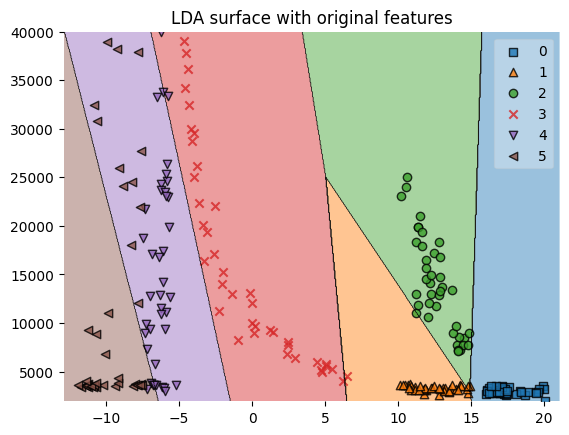

In [17]:
feature_indexes = [3, 0]
sk_lda1 = LinearDiscriminantAnalysis(solver='eigen')
sk_lda1.fit(X1_train[:, feature_indexes], y1_train)
plt.title('LDA surface with original features')
plot_decision_regions(X=X1[:, feature_indexes], y=y1, clf=sk_lda1)

/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


<Axes: title={'center': 'LDA surface with transformed features'}>

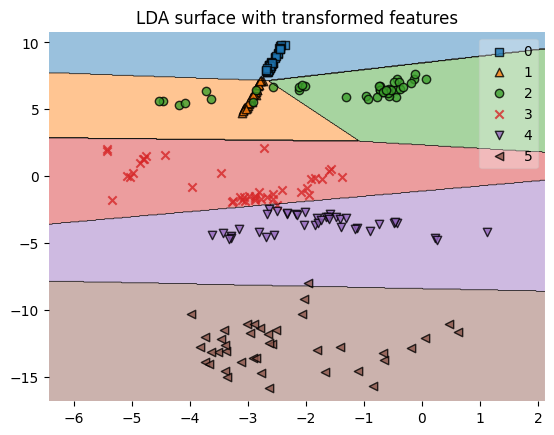

In [18]:
feature_indexes = [3, 0]
sk_lda2 = LinearDiscriminantAnalysis(solver='eigen')
X1_lda = sk_lda2.fit(X1, y1).transform(X1)
X1_lda = X1_lda[:, feature_indexes]
X1_lda_train, X1_lda_test, y1_train, y1_test = train_test_split(X1_lda, y1, random_state=0)
sk_lda2.fit(X1_lda_train, y1_train)
plt.title('LDA surface with transformed features')
plot_decision_regions(X=X1_lda, y=y1, clf=sk_lda2)

### **Pros and cons of LDA**

Pros:
- a simple and effective method for linear classification and dimensionality reduction;
- takes into account the differences between classes and within classes;
- works well when classes have a normal distribution and the same covariance matrix.

Cons:
- it takes enough data for each class to estimate the scatter matrices;
- sensitive to outliers and violation of assumptions about normality and homoscedasticity;
- it may be ineffective when the number of features greatly exceeds the number of objects.

### **Additional sources**
Paper «Linear and Quadratic Discriminant Analysis: Tutorial», Benyamin Ghojogh, Mark Crowley.

Documentation:
- [Discriminant Analysis description](https://scikit-learn.org/stable/modules/lda_qda.html);
- [LDA](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html);
- [QDA](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html).

Video: [one](https://www.youtube.com/watch?v=julEqA2ozcA), [two](https://www.youtube.com/watch?v=9SuIE_tGF-g), [three](https://www.youtube.com/watch?v=azXCzI57Yfc), [four](https://www.youtube.com/watch?v=C0u_v7vEDBY&t=799s).
